In [1]:
import sys
import cuentitas

from auxiliares import generadorFran
from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
import random

import time

import pymc3 as pm

sns.set() #seaborn como default

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def toFitFran(ep1,ep2,d,s1,l1,s2,l2,anguloR,landa):
    '''
    funcion a fitear. 
    Es un wrap de generadorFran
    devuelve un tensor
    '''

    s0s = generadorFran(ep1,ep2,d,s1,l1,s2,l2,incAng,landa)
    
    pp = len(s0s[1])
    
    a = TT.zeros(pp)
#     print(s0s[1][0])
    for i in range(pp):
        a = TT.set_subtensor(a[i], s0s[1][i])
    
    
    return a

In [3]:
def modelo(sector, angWR, landa, samples, sigmas):
    '''
    wrap del modelo bayesiano
    
    angWR es el angulo sin ruido para simulaciones con emisividad, es indistinto el valor 
que tome si uso la f() sin emisividad
    '''
    titas = sector[0]
    observaciones = sector[1]
    
    print('Fiteando '+str(observaciones))
    
#     print(sector[1])
#     print(sector[1].shape)

    
    ranges = {}
    ranges['ep1'] = 1.1, 8
    ranges['ep2'] = 1.1, 8
    ranges['d'] = 0.01, 0.5
    ranges['s1'] = 0.0001, 0.003
    ranges['s2'] = 0.0001, 0.003

    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
        d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])

    def f(ep1 = ep1,
          ep2 = ep2,
          d = d,
          s1 = s1,
          s2 = s2):
        return toFitFran(ep1,ep2,d,s1,l1_in,s2,l2_in,titas,landa)
    
    with model:
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=observaciones)
        trace = pm.sample_smc(samples, cores=4, parallel=True)  
    
    return trace

In [4]:
'''
Parametros de la simulacion
'''

landa = [0.025]
# incAng = [15,20,25]
incAng = [15,25]
# incAng = [20]
landa = [0.025,0.05]

titaEmi = np.asarray([0.0001])


eps1_in = 1.93
eps2_in = 5.0
d_in = 0.3
s1_in = 0.001
l1_in = 0.01
s2_in = 0.001
l2_in = 0.01

In [5]:
#testeo generador frab

generadorFran(eps1_in,
                eps2_in,
                d_in,
                s1_in,
                l1_in,
                s2_in,
                l2_in,
                incAng,
                landa)

array([array([15, 25]),
       array([ -8.79971909, -18.31713625, -11.94684155, -20.96816719,
                0.98661683,   0.99864971])                           ],
      dtype=object)

In [6]:
#testeo toFitFran
qw = toFitFran(eps1_in,
                eps2_in,
                d_in,
                s1_in,
                l1_in,
                s2_in,
                l2_in,
                incAng,
                landa)

qw.eval()

array([ -8.79971909, -18.31713625, -11.94684155, -20.96816719,
         0.98661683,   0.99864971])

In [7]:
muestras = 20000
Nombre = 'Chicote'

sig = np.asarray(len(incAng)*len(landa)*[0.1] + len(landa)*[0.1])


# sig = np.asarray(len(incAng)*[0.1])  #pruebas error

traza = modelo(generadorFran(eps1_in,
                              eps2_in,
                              d_in,
                              s1_in,
                              l1_in,
                              s2_in,
                              l2_in,
                              incAng,
                              landa),
                              titaEmi,
                              landa,
                              muestras,
                              sig)

#------------ error para generadorEmisividad()) ------------#
# sig = np.asarray(len(angR)*[noiseSTD**2] + len(ang)*[0.001])
# traza = modelo([angR,seR],ang,muestras,sig)

Fiteando [ -8.79971909 -18.31713625 -11.94684155 -20.96816719   0.98661683
   0.99864971]


Initializing SMC sampler...
Multiprocess sampling (4 chains in 4 jobs)
INFO (theano.gof.compilelock): Waiting for existing lock by process '8742' (I am process '8741')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/fran/.theano/compiledir_Linux-5.11--generic-x86_64-with-debian-bullseye-sid-x86_64-3.7.11-64/lock_dir
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.001
Stage:   2 Beta: 0.006
Stage:   3 Beta: 0.018
Stage:   4 Beta: 0.040
Stage:   5 Beta: 0.085
Stage:   6 Beta: 0.176
Stage:   7 Beta: 0.360
Stage:   8 Beta: 0.837
Stage:   9 Beta: 1.000


In [8]:
import arviz as az

In [9]:
az_trace = az.from_pymc3(traza)

/home/fran/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


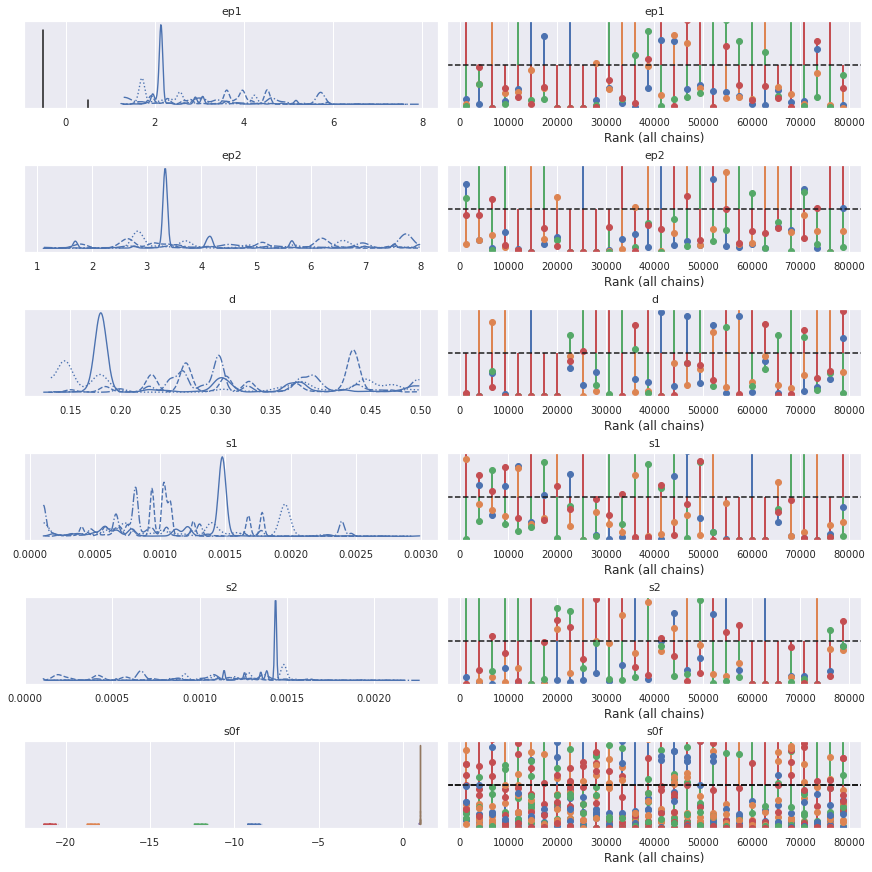

In [36]:
# h = plt.figure(figsize=(10, 7.5))

ax = az.plot_trace(az_trace, compact=True, kind="rank_vlines")
ax[0, 0].axvline(-0.5, 0, 0.9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k");



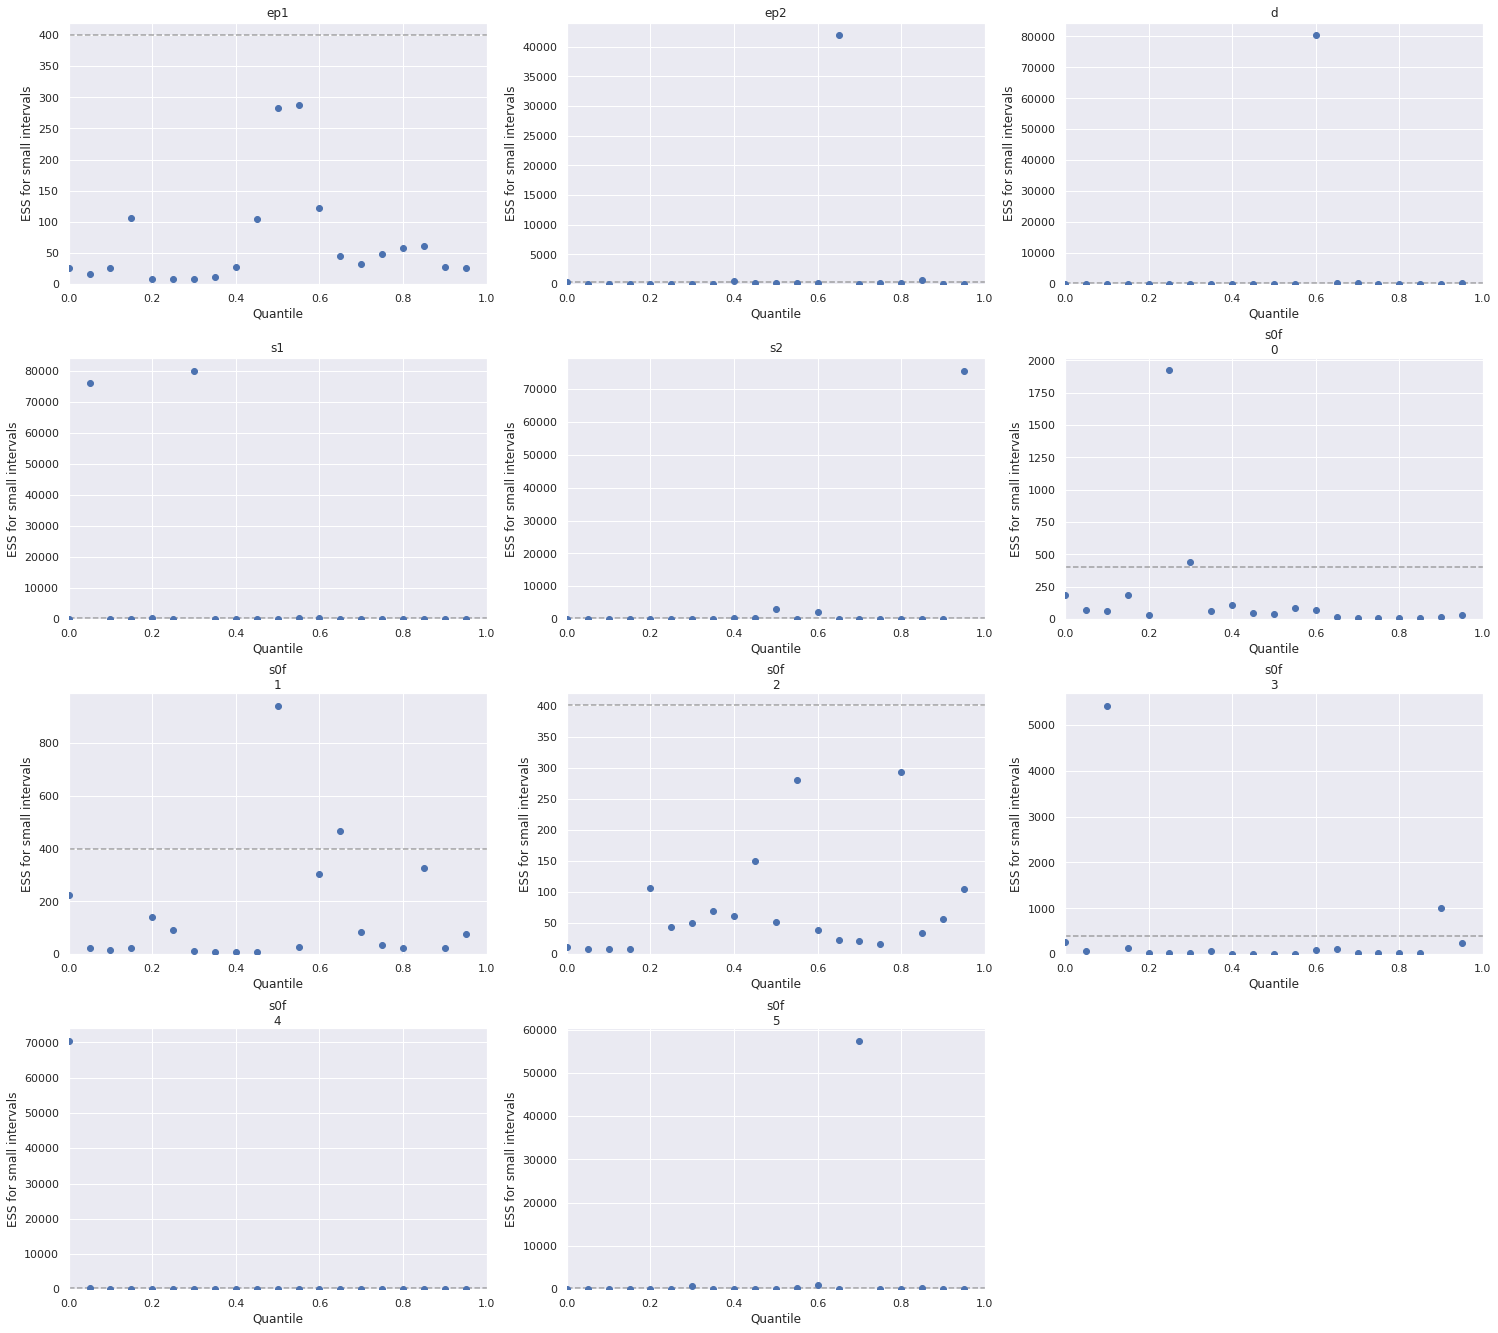

In [38]:
# i = plt.figure(figsize=(7.5, 7.5))

az.plot_ess(az_trace);
i = plt.gcf()

In [12]:
trazaObs = traza['s0f']

In [13]:
trazaObs.shape

(80000, 6)

In [14]:
ns0Obs = trazaObs.shape[1]

In [15]:
ns0Obs

6

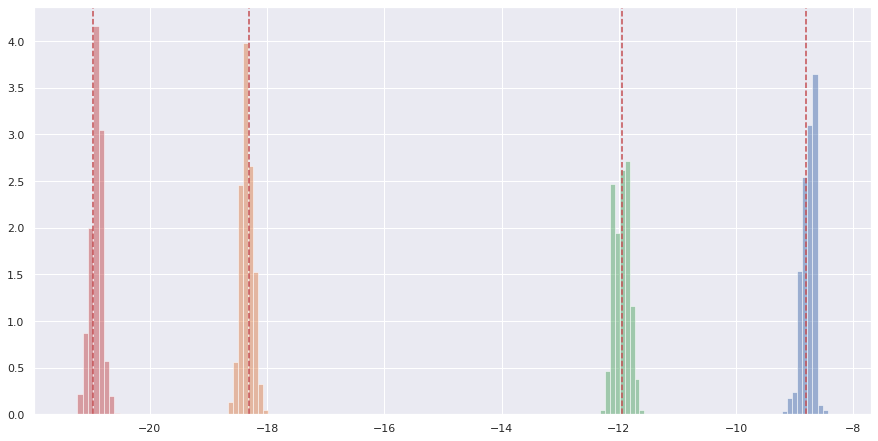

In [16]:
g = plt.figure(figsize=(15, 7.5))

for ind in range(4):

    plt.hist(trazaObs[:,ind], alpha=0.5, density=True)

    s0Posta = generadorFran(eps1_in,
                    eps2_in,
                    d_in,
                    s1_in,
                    l1_in,
                    s2_in,
                    l2_in,
                    incAng,
                    landa)[1][ind]

    plt.axvline(s0Posta, color='r', linestyle='--')

In [17]:
# f.savefig(path+'/'+folderName+'.png', dpi=300)

In [18]:
plotear = np.stack((traza['ep1'], traza['ep2'], traza['d'], traza['s1'], traza['s2'])).T
dfplotear = pd.DataFrame(plotear, columns = ['ep1', 'ep2', 'd', 's1', 's2'])

In [19]:
#Ploteo


# g = sns.PairGrid(dfplotear)
# g.fig.suptitle(Nombre, y=1.01, fontsize = 'large')
# # g.map_upper(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True, color='.5')
# g.savefig(Nombre+'.png')

In [20]:
# modelIn = [1.93,5,0.05,0.0017,0.015,0.003,0.01]
# modelInReduced = [surfaceModelParam[0], 
#                   surfaceModelParam[1],
#                   surfaceModelParam[2],
#                   surfaceModelParam[3],
#                   surfaceModelParam[5]]

modelInReduced = [eps1_in,
                eps2_in,
                d_in,
                s1_in,
                s2_in]

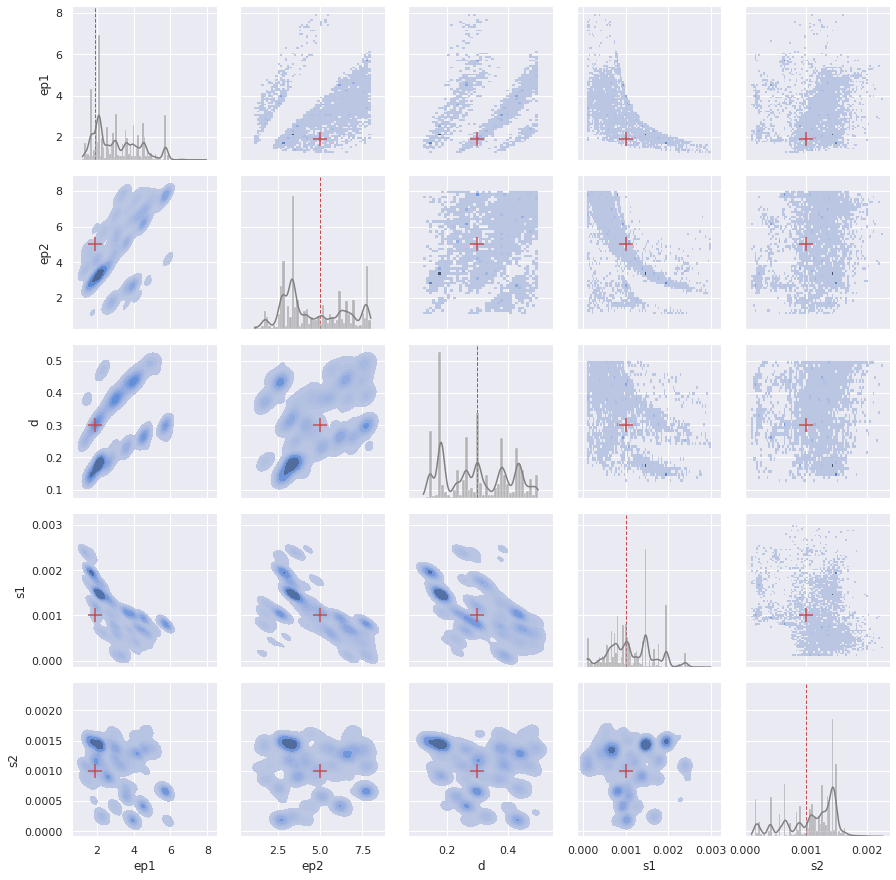

In [21]:
f = sns.PairGrid(dfplotear)
# f.fig.suptitle(Nombre, y=1.01, fontsize = 'large')
f.map_upper(sns.histplot)

f.map_lower(sns.kdeplot, fill=True)
f.map_diag(sns.histplot, kde=True, color='.5')

for i in range(5):
    for j in range(5):
        if i == j:
            #ploteo el valor verdadero en las marginales
            f.axes[j,i].axvline(modelInReduced[i], color='r', linestyle='dashed', linewidth=1)
        else:
            f.axes[j,i].scatter(modelInReduced[i], modelInReduced[j], marker="+", c='r', s=200) #color='k', linestyle='dashed', linewidth=1)
    

In [26]:
# saving
import os

nCapas = '2Capas'
ns0s = str(len(incAng))+'s0s'
nBandas = str(len(landa))+'freq'
exp = '1'

folderName = 'set3-noNoise'+ns0s+nCapas+nBandas

In [27]:
folderName

'set3-noNoise2s0s2Capas2freq'

In [28]:
currentDir = os.getcwd()
path = os.path.join(currentDir, folderName)
os.mkdir(path)

In [29]:
path

'/home/fran/proyectos/TesisJavi/set3-noNoise2s0s2Capas2freq'

In [30]:
f.savefig(path+'/'+folderName+'.png', dpi=300)

In [31]:
g.savefig(path+'/'+folderName+'s0s.png', dpi=300)

In [37]:
h.savefig(path+'/'+folderName+'traces.png', dpi=300)

In [39]:
i.savefig(path+'/'+folderName+'ess.png', dpi=300)

In [34]:
e1 = traza['ep1']
e2 = traza['ep2']
d = traza['d']
s1 = traza['s1']
s2 = traza['s2']

guardar = [e1,e2,d,s1,s2]

f_ = np.savetxt(path+'/'+Nombre+'Trazas.txt', guardar, delimiter=';')
f2_ = np.savetxt(path+'/'+Nombre+'Trazas-input.txt', np.asarray([np.asarray(incAng),np.asarray(modelInReduced)],dtype=object), fmt='%s', delimiter=';')


In [ ]:
fig_ = plt.figure(figsize=(15, 7.5))
plt.scatter(dfplotear.ep1, dfplotear.ep2, marker="+", c='r', s=1)
plt.scatter(modelInReduced[0], modelInReduced[1], marker="+", c='b', s=100)

In [ ]:
dfplotear.ep1.values.shape